In [5]:
import thicket as th
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import os
import sys
sys.path.append(
    "/scratch/group/csce-435-f25/python-3.10.8/lib/python3.10/site-packages")


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
cali_files = glob("cali-files/*.cali")
tk = th.Thicket.from_caliperreader(cali_files)
df = tk.dataframe.reset_index()
# df.columns.tolist()
# # print("First few rows:\n", df.head())
# print("First few metadata rows:\n", tk.metadata.head())
# print(tk.tree(metric_column="Avg time/rank"))
df_merged = df.merge(tk.metadata, left_on='profile', right_index=True)
# df_merged
df = df_merged

(2/2) Creating Thicket: 100%|██████████| 559/559 [00:08<00:00, 62.77it/s]


In [9]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2025.1.0

1.207 main
├─ 0.034 data_init_runtime
├─ 0.147 comp
│  ├─ 0.106 comp_small_merge_sort
│  └─ 0.082 comp_large_merge_arrays
├─ 0.011 comm
│  ├─ 0.011 comm_large_recv
│  └─ 0.006 comm_large_send
└─ 0.023 correctness_check

Legend (Metric: Avg time/rank Min: 0.01 Max: 1.21 indices: {'profile': np.int64(312997649)})
█ 1.09 - 1.21
█ 0.85 - 1.09
█ 0.61 - 0.85
█ 0.37 - 0.61
█ 0.13 - 0.37
█ 0.01 - 0.13

name User code    ◀  Only in left graph    ▶  Only in right graph



/tmp/ipykernel_851917/2892209884.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Input Type', loc='best')


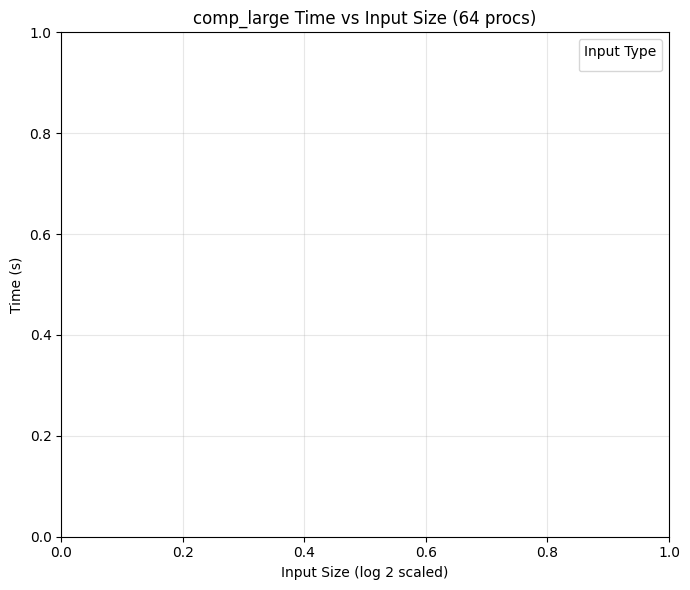

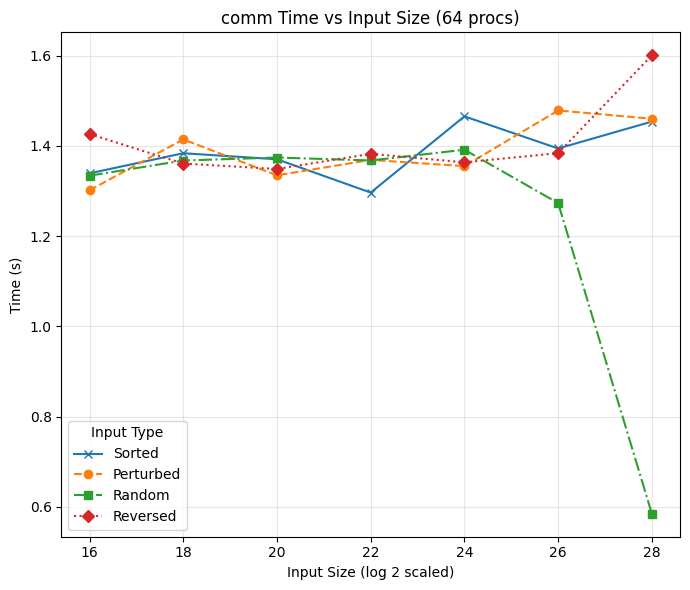

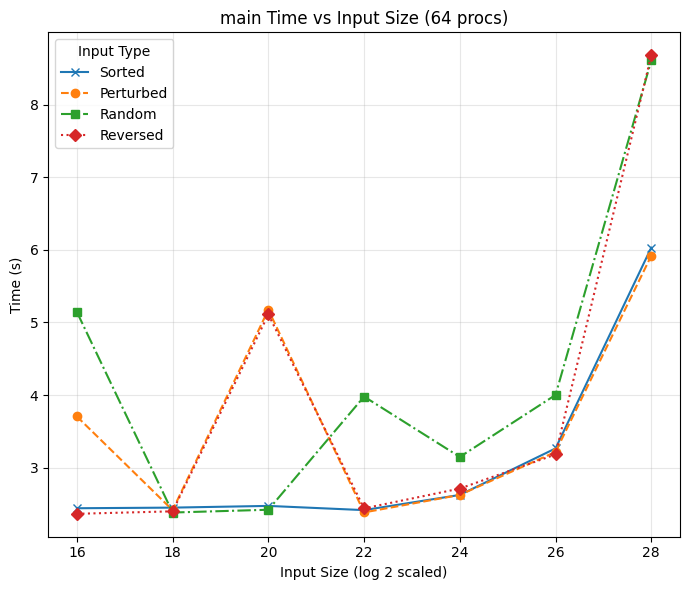

In [8]:
# === Merge Sort Caliper Analysis with Thicket ===

# Load Caliper files and Thicket
# df = df_merged already set above
input_type_map = {0: 'Sorted', 1: 'Perturbed', 2: 'Random', 3: 'Reversed'}
regions = ['comp_large', 'comm', 'main']
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
input_types = [0, 1, 2, 3]
num_procs_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
time_col = 'Max time/rank' if 'Max time/rank' in df.columns else 'time'

# --- Plot Style ---
os.makedirs('plots', exist_ok=True)
plt.style.use('default')
color_list = None # Use default matplotlib colors
marker_list = ['x', 'o', 's', 'D']
line_styles = ['-', '--', '-.', ':']

# --- Experiment 1: 2 nodes, 64 processes, vary number of elements ---
fixed_procs = 64
for region in regions:
    fig, ax = plt.subplots(figsize=(7, 6))
    for idx, input_type in enumerate(input_types):
        times, sizes = [], []
        for input_size in input_sizes:
            mask = (df['name'] == region) & \
                   (df['input_size'] == input_size) & \
                   (df['num_procs'] == fixed_procs) & \
                   (df['input_type'] == input_type)
            data = df[mask]
            if len(data) > 0:
                times.append(data[time_col].iloc[0])
                sizes.append(input_size)
        if len(times) > 0:
            ax.plot([np.log2(s) for s in sizes], times,
                    marker=marker_list[idx], linestyle=line_styles[idx],
                    label=input_type_map[input_type])
    ax.set_xlabel('Input Size (log 2 scaled)')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'{region} Time vs Input Size (64 procs)')
    ax.grid(True, alpha=0.3)
    ax.legend(title='Input Type', loc='best')
    plt.tight_layout()
    plt.savefig(f'plots/exp1_{region}_64procs.png', dpi=150, bbox_inches='tight')
    plt.show()

# # --- Experiment 2: Strong scaling (2^22 elements, vary number of processes) ---
# fixed_size = 2**22
# for region in regions:
#     fig, ax = plt.subplots(figsize=(7, 6))
#     for idx, input_type in enumerate(input_types):
#         times, procs = [], []
#         for num_proc in num_procs_list:
#             mask = (df['name'] == region) & \
#                    (df['input_size'] == fixed_size) & \
#                    (df['num_procs'] == num_proc) & \
#                    (df['input_type'] == input_type)
#             data = df[mask]
#             if len(data) > 0:
#                 times.append(data[time_col].iloc[0])
#                 procs.append(num_proc)
#         if len(times) > 0:
#             ax.plot(procs, times,
#                     marker=marker_list[idx], linestyle=line_styles[idx],
#                     label=input_type_map[input_type])
#     ax.set_xlabel('Number of Processes')
#     ax.set_ylabel('Time (s)')
#     ax.set_title(f'{region} Strong Scaling (2^22 elements)')
#     ax.set_xscale('log', base=2)
#     ax.grid(True, alpha=0.3)
#     ax.legend(title='Input Type', loc='best')
#     plt.tight_layout()
#     plt.savefig(f'plots/exp2_{region}_strong_scaling.png', dpi=150, bbox_inches='tight')
#     plt.show()

# # --- Experiment 3: Weak scaling ---
# weak_scaling_configs = [
#     (2**16, 16), (2**18, 32), (2**20, 64),
#     (2**22, 128), (2**24, 256), (2**26, 512), (2**28, 1024)
#     ]
# for region in regions:
#     fig, ax = plt.subplots(figsize=(7, 6))
#     for idx, input_type in enumerate(input_types):
#         times, procs = [], []
#         for input_size, num_proc in weak_scaling_configs:
#             mask = (df['name'] == region) & \
#                    (df['input_size'] == input_size) & \
#                    (df['num_procs'] == num_proc) & \
#                    (df['input_type'] == input_type)
#             data = df[mask]
#             if len(data) > 0:
#                 times.append(data[time_col].iloc[0])
#                 procs.append(num_proc)
#         if len(times) > 0:
#             ax.plot(procs, times,
#                     marker=marker_list[idx], linestyle=line_styles[idx],
#                     label=input_type_map[input_type])
#             ax.axhline(y=times[0], linestyle=':', alpha=0.5)
#     ax.set_xlabel('Number of Processes')
#     ax.set_ylabel('Time (s)')
#     ax.set_title(f'{region} Weak Scaling')
#     ax.set_xscale('log', base=2)
#     ax.grid(True, alpha=0.3)
#     ax.legend(title='Input Type', loc='best')
#     plt.tight_layout()
#     plt.savefig(f'plots/exp3_{region}_weak_scaling.png', dpi=150, bbox_inches='tight')
#     plt.show()

# # --- Experiment 4: Data type comparison (int vs float) ---
# if 'data_type' in df.columns:
#     for region in regions:
#         fig, ax = plt.subplots(figsize=(7, 6))
#         width = 0.35
#         for idx, data_type in enumerate(df['data_type'].unique()):
#             times, types = [], []
#             for input_type in input_types:
#                 mask = (df['name'] == region) & \
#                        (df['input_size'] == fixed_size) & \
#                        (df['num_procs'] == fixed_procs) & \
#                        (df['input_type'] == input_type) & \
#                        (df['data_type'] == data_type)
#                 data = df[mask]
#                 if len(data) > 0:
#                     times.append(data[time_col].iloc[0])
#                     types.append(input_type_map[input_type])
#             if len(times) > 0:
#                 x_pos = np.arange(len(types)) + idx * width
#                 ax.bar(x_pos, times, width=width, label=data_type)
#         ax.set_xlabel('Input Type')
#         ax.set_ylabel('Time (s)')
#         ax.set_title(f'{region} Data Type Comparison (2^22 elements, 64 procs)')
#         ax.set_xticks(np.arange(len(input_types)) + width/2)
#         ax.set_xticklabels([input_type_map[t] for t in input_types])
#         ax.legend(title='Data Type', loc='best')
#         ax.grid(True, alpha=0.3, axis='y')
#         plt.tight_layout()
#         plt.savefig(f'plots/exp4_{region}_datatype.png', dpi=150, bbox_inches='tight')
#         plt.show()
# else:
#     print("Warning: 'data_type' column not found. Run experiments with both int and float.")

# # --- Experiment 5: Input type comparison (2^22 elements, 64 processes) ---
# for region in regions:
#     fig, ax = plt.subplots(figsize=(7, 6))
#     times, labels = [], []
#     for idx, input_type in enumerate(input_types):
#         mask = (df['name'] == region) & \
#                (df['input_size'] == fixed_size) & \
#                (df['num_procs'] == fixed_procs) & \
#                (df['input_type'] == input_type)
#         data = df[mask]
#         if len(data) > 0:
#             times.append(data[time_col].iloc[0])
#             labels.append(input_type_map[input_type])
#     if len(times) > 0:
#         bars = ax.bar(labels, times)
#         ax.set_ylabel('Time (s)')
#         ax.set_title(f'{region} Input Type Comparison (2^22 elements, 64 procs)')
#         ax.grid(True, alpha=0.3, axis='y')
#         for bar in bars:
#             height = bar.get_height()
#             ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}s', ha='center', va='bottom')
#         plt.tight_layout()
#         plt.savefig(f'plots/exp5_{region}_inputtype.png', dpi=150, bbox_inches='tight')
#         plt.show()